# Training with different topologies

Int this tutorial, you will learn how to use EncoderMap's new sparse trainign feature to learn the conformations of multiple proteins with different topologies.

Run this notebook on Google Colab:

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AG-Peter/encodermap/blob/main/tutorials/notebooks_intermediate/02_training_with_different_topologies.ipynb)

Find the documentation of EncoderMap:

https://ag-peter.github.io/encodermap

## Install encodermap on Google colab

If you are on Google colab, please uncomment this line and install encodermap:

In [1]:
# !pip install "git+https://github.com/AG-Peter/encodermap.git@main"
# !pip install -r pip install -r https://raw.githubusercontent.com/AG-Peter/encodermap/main/tests/test_requirements.md

## Imports

In [2]:
import encodermap as em
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

2023-02-06 17:11:38.405396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 17:11:38.533605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-06 17:11:38.533632: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-02-06 17:11:39.184052: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-06 17:11:39.184135: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-06 17:11:39.184143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Fix tensorflow seed for reproducibility

In [3]:
import tensorflow as tf
tf.random.set_seed(1)

## Load the trajectories

We use EncoderMap's `TrajEnsemble` class to load the trajectories and do the feature alignment.

In [4]:
traj_files = ["glu7.xtc", "asp7.xtc"]
top_files = ["glu7.pdb", "asp7.pdb"]

trajs = em.load(traj_files, top_files)

Load the CVs with the `ensemble=True` options.

In [5]:
trajs.load_CVs("all", ensemble=True)

In [6]:
trajs

<encodermap.TrajEnsemble object. Current backend is no_load. Containing 20002 frames. CV central_dihedrals with shape (20002, 18) loaded. CV central_distances with shape (20002, 20) loaded. CV side_dihedrals with shape (20002, 21) loaded. CV central_cartesians with shape (20002, 21, 3) loaded. CV central_angles with shape (20002, 19) loaded. Object at 0x7f92b4ed8a30>

## Create the AngleDihedralCartesianEncoderMap

The AngleDihedralCartesianEncoderMap tries to learn all of the geometric features of a protein. The angles (backbone angles, backbone dihedrals, sidechain dihedrals) are passed through a neuronal network autoencoder, while the distances between the backbone atoms are used to create cartesian coordinates from the learned angles. The generated cartesians and the input (true) cartesians are used to construct pairwise C$_\alpha$ distances, which are then also weighted using sketchmap's sigmoid function. The `cartesian_cost_scale_soft_start` gradually increases the contribution of this cost function to the overall model loss.

In [7]:
p = em.ADCParameters(use_backbone_angles=True,
                     distance_cost_scale=1,
                     auto_cost_scale=0.1,
                     cartesian_cost_scale_soft_start=(50, 80),
                     n_neurons = [500, 250, 125, 2],
                     activation_functions = ['', 'tanh', 'tanh', 'tanh', ''],
                     use_sidechains=True,
                     summary_step=1,
                     tensorboard=True,
                     periodicity=2*np.pi,
                     n_steps=100,
                     checkpoint_step=1000,
                     dist_sig_parameters = (4.5, 12, 6, 1, 2, 6),
                     main_path=em.misc.run_path('runs/asp7_glu7_asp8'),
                     model_api='functional',
                    )
emap = em.AngleDihedralCartesianEncoderMap(trajs, p)

Output files are saved to runs/asp7_glu7_asp8/run0 as defined in 'main_path' in the parameters.
Input contains nans. Using sparse network.


2023-02-06 17:11:43.598384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-06 17:11:43.598414: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 17:11:43.598434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az570-137): /proc/driver/nvidia/version does not exist
2023-02-06 17:11:43.598684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


input shapes are:
{'central_dihedrals': (20002, 18), 'central_distances': (20002, 20), 'side_dihedrals': TensorShape([20002, 21]), 'central_cartesians': (20002, 21, 3), 'central_angles': (20002, 19)}
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Saved a text-summary of the model and an image in runs/asp7_glu7_asp8/run0, as specified in 'main_path' in the parameters.


train

In [8]:
emap.train()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s, Loss after step ?=?, Cartesian cost Scale=?]

  0%|          | 0/100 [00:23<?, ?it/s, Loss after step 1=6.28, Cartesian cost Scale=0]

  1%|          | 1/100 [00:23<39:15, 23.79s/it, Loss after step 1=6.28, Cartesian cost Scale=0]

  1%|          | 1/100 [00:23<39:15, 23.79s/it, Loss after step 2=5.47, Cartesian cost Scale=0]

  2%|▏         | 2/100 [00:23<38:51, 23.79s/it, Loss after step 3=5.02, Cartesian cost Scale=0]

  3%|▎         | 3/100 [00:23<10:05,  6.24s/it, Loss after step 3=5.02, Cartesian cost Scale=0]

  3%|▎         | 3/100 [00:24<10:05,  6.24s/it, Loss after step 4=4.75, Cartesian cost Scale=0]

  4%|▍         | 4/100 [00:24<09:59,  6.24s/it, Loss after step 5=4.54, Cartesian cost Scale=0]

  5%|▌         | 5/100 [00:24<04:52,  3.08s/it, Loss after step 5=4.54, Cartesian cost Scale=0]

  5%|▌         | 5/100 [00:24<04:52,  3.08s/it, Loss after step 6=4.37, Cartesian cost Scale=0]

  6%|▌         | 6/100 [00:24<04:49,  3.08s/it, Loss after step 7=4.29, Cartesian cost Scale=0]

  7%|▋         | 7/100 [00:24<02:48,  1.81s/it, Loss after step 7=4.29, Cartesian cost Scale=0]

  7%|▋         | 7/100 [00:24<02:48,  1.81s/it, Loss after step 8=4.17, Cartesian cost Scale=0]

  8%|▊         | 8/100 [00:24<02:46,  1.81s/it, Loss after step 9=4.1, Cartesian cost Scale=0] 

  9%|▉         | 9/100 [00:24<01:45,  1.16s/it, Loss after step 9=4.1, Cartesian cost Scale=0]

  9%|▉         | 9/100 [00:24<01:45,  1.16s/it, Loss after step 10=4.02, Cartesian cost Scale=0]

 10%|█         | 10/100 [00:24<01:44,  1.16s/it, Loss after step 11=4, Cartesian cost Scale=0]  

 11%|█         | 11/100 [00:24<01:10,  1.27it/s, Loss after step 11=4, Cartesian cost Scale=0]

 11%|█         | 11/100 [00:24<01:10,  1.27it/s, Loss after step 12=3.95, Cartesian cost Scale=0]

 12%|█▏        | 12/100 [00:24<01:09,  1.27it/s, Loss after step 13=3.95, Cartesian cost Scale=0]

 13%|█▎        | 13/100 [00:24<00:48,  1.79it/s, Loss after step 13=3.95, Cartesian cost Scale=0]

 13%|█▎        | 13/100 [00:25<00:48,  1.79it/s, Loss after step 14=3.89, Cartesian cost Scale=0]

 14%|█▍        | 14/100 [00:25<00:47,  1.79it/s, Loss after step 15=3.94, Cartesian cost Scale=0]

 15%|█▌        | 15/100 [00:25<00:34,  2.45it/s, Loss after step 15=3.94, Cartesian cost Scale=0]

 15%|█▌        | 15/100 [00:25<00:34,  2.45it/s, Loss after step 16=3.85, Cartesian cost Scale=0]

 16%|█▌        | 16/100 [00:25<00:34,  2.45it/s, Loss after step 17=3.85, Cartesian cost Scale=0]

 17%|█▋        | 17/100 [00:25<00:25,  3.22it/s, Loss after step 17=3.85, Cartesian cost Scale=0]

 17%|█▋        | 17/100 [00:25<00:25,  3.22it/s, Loss after step 18=3.83, Cartesian cost Scale=0]

 18%|█▊        | 18/100 [00:25<00:25,  3.22it/s, Loss after step 19=3.79, Cartesian cost Scale=0]

 19%|█▉        | 19/100 [00:25<00:19,  4.12it/s, Loss after step 19=3.79, Cartesian cost Scale=0]

 19%|█▉        | 19/100 [00:25<00:19,  4.12it/s, Loss after step 20=3.76, Cartesian cost Scale=0]

 20%|██        | 20/100 [00:25<00:19,  4.12it/s, Loss after step 21=3.75, Cartesian cost Scale=0]

 21%|██        | 21/100 [00:25<00:15,  5.08it/s, Loss after step 21=3.75, Cartesian cost Scale=0]

 21%|██        | 21/100 [00:25<00:15,  5.08it/s, Loss after step 22=3.73, Cartesian cost Scale=0]

 22%|██▏       | 22/100 [00:25<00:15,  5.08it/s, Loss after step 23=3.71, Cartesian cost Scale=0]

 23%|██▎       | 23/100 [00:25<00:12,  6.09it/s, Loss after step 23=3.71, Cartesian cost Scale=0]

 23%|██▎       | 23/100 [00:25<00:12,  6.09it/s, Loss after step 24=3.71, Cartesian cost Scale=0]

 24%|██▍       | 24/100 [00:26<00:12,  6.09it/s, Loss after step 25=3.66, Cartesian cost Scale=0]

 25%|██▌       | 25/100 [00:26<00:10,  7.01it/s, Loss after step 25=3.66, Cartesian cost Scale=0]

 25%|██▌       | 25/100 [00:26<00:10,  7.01it/s, Loss after step 26=3.66, Cartesian cost Scale=0]

 26%|██▌       | 26/100 [00:26<00:10,  7.01it/s, Loss after step 27=3.61, Cartesian cost Scale=0]

 27%|██▋       | 27/100 [00:26<00:09,  7.87it/s, Loss after step 27=3.61, Cartesian cost Scale=0]

 27%|██▋       | 27/100 [00:26<00:09,  7.87it/s, Loss after step 28=3.61, Cartesian cost Scale=0]

 28%|██▊       | 28/100 [00:26<00:09,  7.87it/s, Loss after step 29=3.6, Cartesian cost Scale=0] 

 29%|██▉       | 29/100 [00:26<00:08,  8.50it/s, Loss after step 29=3.6, Cartesian cost Scale=0]

 29%|██▉       | 29/100 [00:26<00:08,  8.50it/s, Loss after step 30=3.64, Cartesian cost Scale=0]

 30%|███       | 30/100 [00:26<00:08,  8.50it/s, Loss after step 31=3.54, Cartesian cost Scale=0]

 31%|███       | 31/100 [00:26<00:07,  9.09it/s, Loss after step 31=3.54, Cartesian cost Scale=0]

 31%|███       | 31/100 [00:26<00:07,  9.09it/s, Loss after step 32=3.56, Cartesian cost Scale=0]

 32%|███▏      | 32/100 [00:26<00:07,  9.09it/s, Loss after step 33=3.53, Cartesian cost Scale=0]

 33%|███▎      | 33/100 [00:26<00:06,  9.58it/s, Loss after step 33=3.53, Cartesian cost Scale=0]

 33%|███▎      | 33/100 [00:26<00:06,  9.58it/s, Loss after step 34=3.53, Cartesian cost Scale=0]

 34%|███▍      | 34/100 [00:26<00:06,  9.58it/s, Loss after step 35=3.45, Cartesian cost Scale=0]

 35%|███▌      | 35/100 [00:26<00:06,  9.82it/s, Loss after step 35=3.45, Cartesian cost Scale=0]

 35%|███▌      | 35/100 [00:27<00:06,  9.82it/s, Loss after step 36=3.45, Cartesian cost Scale=0]

 36%|███▌      | 36/100 [00:27<00:06,  9.82it/s, Loss after step 37=3.4, Cartesian cost Scale=0] 

 37%|███▋      | 37/100 [00:27<00:06, 10.03it/s, Loss after step 37=3.4, Cartesian cost Scale=0]

 37%|███▋      | 37/100 [00:27<00:06, 10.03it/s, Loss after step 38=3.4, Cartesian cost Scale=0]

 38%|███▊      | 38/100 [00:27<00:06, 10.03it/s, Loss after step 39=3.41, Cartesian cost Scale=0]

 39%|███▉      | 39/100 [00:27<00:05, 10.22it/s, Loss after step 39=3.41, Cartesian cost Scale=0]

 39%|███▉      | 39/100 [00:27<00:05, 10.22it/s, Loss after step 40=3.36, Cartesian cost Scale=0]

 40%|████      | 40/100 [00:27<00:05, 10.22it/s, Loss after step 41=3.32, Cartesian cost Scale=0]

 41%|████      | 41/100 [00:27<00:05, 10.41it/s, Loss after step 41=3.32, Cartesian cost Scale=0]

 41%|████      | 41/100 [00:27<00:05, 10.41it/s, Loss after step 42=3.35, Cartesian cost Scale=0]

 42%|████▏     | 42/100 [00:27<00:05, 10.41it/s, Loss after step 43=3.33, Cartesian cost Scale=0]

 43%|████▎     | 43/100 [00:27<00:05, 10.48it/s, Loss after step 43=3.33, Cartesian cost Scale=0]

 43%|████▎     | 43/100 [00:27<00:05, 10.48it/s, Loss after step 44=3.33, Cartesian cost Scale=0]

 44%|████▍     | 44/100 [00:27<00:05, 10.48it/s, Loss after step 45=3.32, Cartesian cost Scale=0]

 45%|████▌     | 45/100 [00:27<00:05, 10.66it/s, Loss after step 45=3.32, Cartesian cost Scale=0]

 45%|████▌     | 45/100 [00:27<00:05, 10.66it/s, Loss after step 46=3.28, Cartesian cost Scale=0]

 46%|████▌     | 46/100 [00:28<00:05, 10.66it/s, Loss after step 47=3.29, Cartesian cost Scale=0]

 47%|████▋     | 47/100 [00:28<00:04, 10.74it/s, Loss after step 47=3.29, Cartesian cost Scale=0]

 47%|████▋     | 47/100 [00:28<00:04, 10.74it/s, Loss after step 48=3.27, Cartesian cost Scale=0]

 48%|████▊     | 48/100 [00:28<00:04, 10.74it/s, Loss after step 49=3.26, Cartesian cost Scale=0]

 49%|████▉     | 49/100 [00:28<00:04, 10.74it/s, Loss after step 49=3.26, Cartesian cost Scale=0]

 49%|████▉     | 49/100 [00:28<00:04, 10.74it/s, Loss after step 50=3.25, Cartesian cost Scale=0]

 50%|█████     | 50/100 [00:28<00:04, 10.74it/s, Loss after step 51=3.25, Cartesian cost Scale=0.03]

 51%|█████     | 51/100 [00:28<00:04, 10.70it/s, Loss after step 51=3.25, Cartesian cost Scale=0.03]

 51%|█████     | 51/100 [00:28<00:04, 10.70it/s, Loss after step 52=3.29, Cartesian cost Scale=0.07]

 52%|█████▏    | 52/100 [00:28<00:04, 10.70it/s, Loss after step 53=3.24, Cartesian cost Scale=0.1] 

 53%|█████▎    | 53/100 [00:28<00:04, 10.59it/s, Loss after step 53=3.24, Cartesian cost Scale=0.1]

 53%|█████▎    | 53/100 [00:28<00:04, 10.59it/s, Loss after step 54=3.25, Cartesian cost Scale=0.13]

 54%|█████▍    | 54/100 [00:28<00:04, 10.59it/s, Loss after step 55=3.24, Cartesian cost Scale=0.17]

 55%|█████▌    | 55/100 [00:28<00:04, 10.62it/s, Loss after step 55=3.24, Cartesian cost Scale=0.17]

 55%|█████▌    | 55/100 [00:28<00:04, 10.62it/s, Loss after step 56=3.22, Cartesian cost Scale=0.2] 

 56%|█████▌    | 56/100 [00:29<00:04, 10.62it/s, Loss after step 57=3.26, Cartesian cost Scale=0.23]

 57%|█████▋    | 57/100 [00:29<00:04, 10.71it/s, Loss after step 57=3.26, Cartesian cost Scale=0.23]

 57%|█████▋    | 57/100 [00:29<00:04, 10.71it/s, Loss after step 58=3.26, Cartesian cost Scale=0.27]

 58%|█████▊    | 58/100 [00:29<00:03, 10.71it/s, Loss after step 59=3.21, Cartesian cost Scale=0.3] 

 59%|█████▉    | 59/100 [00:29<00:03, 10.83it/s, Loss after step 59=3.21, Cartesian cost Scale=0.3]

 59%|█████▉    | 59/100 [00:29<00:03, 10.83it/s, Loss after step 60=3.24, Cartesian cost Scale=0.33]

 60%|██████    | 60/100 [00:29<00:03, 10.83it/s, Loss after step 61=3.19, Cartesian cost Scale=0.37]

 61%|██████    | 61/100 [00:29<00:03, 10.86it/s, Loss after step 61=3.19, Cartesian cost Scale=0.37]

 61%|██████    | 61/100 [00:29<00:03, 10.86it/s, Loss after step 62=3.15, Cartesian cost Scale=0.4] 

 62%|██████▏   | 62/100 [00:29<00:03, 10.86it/s, Loss after step 63=3.13, Cartesian cost Scale=0.43]

 63%|██████▎   | 63/100 [00:29<00:03, 10.70it/s, Loss after step 63=3.13, Cartesian cost Scale=0.43]

 63%|██████▎   | 63/100 [00:29<00:03, 10.70it/s, Loss after step 64=3.16, Cartesian cost Scale=0.47]

 64%|██████▍   | 64/100 [00:29<00:03, 10.70it/s, Loss after step 65=3.14, Cartesian cost Scale=0.5] 

 65%|██████▌   | 65/100 [00:29<00:03, 10.61it/s, Loss after step 65=3.14, Cartesian cost Scale=0.5]

 65%|██████▌   | 65/100 [00:29<00:03, 10.61it/s, Loss after step 66=3.14, Cartesian cost Scale=0.53]

 66%|██████▌   | 66/100 [00:29<00:03, 10.61it/s, Loss after step 67=3.15, Cartesian cost Scale=0.57]

 67%|██████▋   | 67/100 [00:29<00:03, 10.50it/s, Loss after step 67=3.15, Cartesian cost Scale=0.57]

 67%|██████▋   | 67/100 [00:30<00:03, 10.50it/s, Loss after step 68=3.12, Cartesian cost Scale=0.6] 

 68%|██████▊   | 68/100 [00:30<00:03, 10.50it/s, Loss after step 69=3.11, Cartesian cost Scale=0.63]

 69%|██████▉   | 69/100 [00:30<00:02, 10.48it/s, Loss after step 69=3.11, Cartesian cost Scale=0.63]

 69%|██████▉   | 69/100 [00:30<00:02, 10.48it/s, Loss after step 70=3.1, Cartesian cost Scale=0.67] 

 70%|███████   | 70/100 [00:30<00:02, 10.48it/s, Loss after step 71=3.09, Cartesian cost Scale=0.7]

 71%|███████   | 71/100 [00:30<00:02, 10.66it/s, Loss after step 71=3.09, Cartesian cost Scale=0.7]

 71%|███████   | 71/100 [00:30<00:02, 10.66it/s, Loss after step 72=3.08, Cartesian cost Scale=0.73]

 72%|███████▏  | 72/100 [00:30<00:02, 10.66it/s, Loss after step 73=3.1, Cartesian cost Scale=0.77] 

 73%|███████▎  | 73/100 [00:30<00:02, 10.74it/s, Loss after step 73=3.1, Cartesian cost Scale=0.77]

 73%|███████▎  | 73/100 [00:30<00:02, 10.74it/s, Loss after step 74=3.08, Cartesian cost Scale=0.8]

 74%|███████▍  | 74/100 [00:30<00:02, 10.74it/s, Loss after step 75=3.08, Cartesian cost Scale=0.83]

 75%|███████▌  | 75/100 [00:30<00:02, 10.69it/s, Loss after step 75=3.08, Cartesian cost Scale=0.83]

 75%|███████▌  | 75/100 [00:30<00:02, 10.69it/s, Loss after step 76=3.04, Cartesian cost Scale=0.87]

 76%|███████▌  | 76/100 [00:30<00:02, 10.69it/s, Loss after step 77=3.02, Cartesian cost Scale=0.9] 

 77%|███████▋  | 77/100 [00:30<00:02, 10.65it/s, Loss after step 77=3.02, Cartesian cost Scale=0.9]

 77%|███████▋  | 77/100 [00:30<00:02, 10.65it/s, Loss after step 78=3.05, Cartesian cost Scale=0.93]

 78%|███████▊  | 78/100 [00:31<00:02, 10.65it/s, Loss after step 79=3.05, Cartesian cost Scale=0.97]

 79%|███████▉  | 79/100 [00:31<00:01, 10.61it/s, Loss after step 79=3.05, Cartesian cost Scale=0.97]

 79%|███████▉  | 79/100 [00:31<00:01, 10.61it/s, Loss after step 80=3.02, Cartesian cost Scale=1]   

 80%|████████  | 80/100 [00:31<00:01, 10.61it/s, Loss after step 81=2.96, Cartesian cost Scale=1]

 81%|████████  | 81/100 [00:31<00:01, 10.70it/s, Loss after step 81=2.96, Cartesian cost Scale=1]

 81%|████████  | 81/100 [00:31<00:01, 10.70it/s, Loss after step 82=2.99, Cartesian cost Scale=1]

 82%|████████▏ | 82/100 [00:31<00:01, 10.70it/s, Loss after step 83=3, Cartesian cost Scale=1]   

 83%|████████▎ | 83/100 [00:31<00:01, 10.75it/s, Loss after step 83=3, Cartesian cost Scale=1]

 83%|████████▎ | 83/100 [00:31<00:01, 10.75it/s, Loss after step 84=3, Cartesian cost Scale=1]

 84%|████████▍ | 84/100 [00:31<00:01, 10.75it/s, Loss after step 85=2.97, Cartesian cost Scale=1]

 85%|████████▌ | 85/100 [00:31<00:01, 10.68it/s, Loss after step 85=2.97, Cartesian cost Scale=1]

 85%|████████▌ | 85/100 [00:31<00:01, 10.68it/s, Loss after step 86=2.99, Cartesian cost Scale=1]

 86%|████████▌ | 86/100 [00:31<00:01, 10.68it/s, Loss after step 87=2.96, Cartesian cost Scale=1]

 87%|████████▋ | 87/100 [00:31<00:01, 10.52it/s, Loss after step 87=2.96, Cartesian cost Scale=1]

 87%|████████▋ | 87/100 [00:31<00:01, 10.52it/s, Loss after step 88=2.92, Cartesian cost Scale=1]

 88%|████████▊ | 88/100 [00:32<00:01, 10.52it/s, Loss after step 89=2.92, Cartesian cost Scale=1]

 89%|████████▉ | 89/100 [00:32<00:01, 10.48it/s, Loss after step 89=2.92, Cartesian cost Scale=1]

 89%|████████▉ | 89/100 [00:32<00:01, 10.48it/s, Loss after step 90=2.9, Cartesian cost Scale=1] 

 90%|█████████ | 90/100 [00:32<00:00, 10.48it/s, Loss after step 91=2.89, Cartesian cost Scale=1]

 91%|█████████ | 91/100 [00:32<00:00, 10.32it/s, Loss after step 91=2.89, Cartesian cost Scale=1]

 91%|█████████ | 91/100 [00:32<00:00, 10.32it/s, Loss after step 92=2.92, Cartesian cost Scale=1]

 92%|█████████▏| 92/100 [00:32<00:00, 10.32it/s, Loss after step 93=2.92, Cartesian cost Scale=1]

 93%|█████████▎| 93/100 [00:32<00:00, 10.41it/s, Loss after step 93=2.92, Cartesian cost Scale=1]

 93%|█████████▎| 93/100 [00:32<00:00, 10.41it/s, Loss after step 94=2.91, Cartesian cost Scale=1]

 94%|█████████▍| 94/100 [00:32<00:00, 10.41it/s, Loss after step 95=2.87, Cartesian cost Scale=1]

 95%|█████████▌| 95/100 [00:32<00:00, 10.50it/s, Loss after step 95=2.87, Cartesian cost Scale=1]

 95%|█████████▌| 95/100 [00:32<00:00, 10.50it/s, Loss after step 96=2.83, Cartesian cost Scale=1]

 96%|█████████▌| 96/100 [00:32<00:00, 10.50it/s, Loss after step 97=2.87, Cartesian cost Scale=1]

 97%|█████████▋| 97/100 [00:32<00:00, 10.52it/s, Loss after step 97=2.87, Cartesian cost Scale=1]

 97%|█████████▋| 97/100 [00:32<00:00, 10.52it/s, Loss after step 98=2.84, Cartesian cost Scale=1]

 98%|█████████▊| 98/100 [00:32<00:00, 10.52it/s, Loss after step 99=2.83, Cartesian cost Scale=1]

 99%|█████████▉| 99/100 [00:32<00:00, 10.68it/s, Loss after step 99=2.83, Cartesian cost Scale=1]

 99%|█████████▉| 99/100 [00:33<00:00, 10.68it/s, Loss after step 100=2.8, Cartesian cost Scale=1]

100%|██████████| 100/100 [00:33<00:00,  3.02it/s, Loss after step 100=2.8, Cartesian cost Scale=1]

## Plot the result

In the result (longer training would be beneficial here), the projection area of asp7 and glu7 are separated.

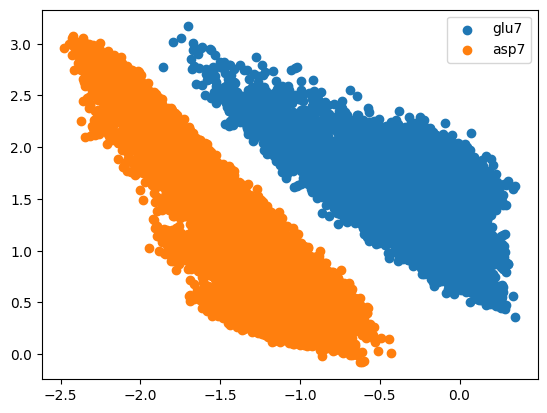

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# generate ids, based on the names of the trajs
ids = (trajs.name_arr == "asp7").astype(int)

ax.scatter(*emap.encode()[ids == 0].T, label="glu7")
ax.scatter(*emap.encode()[ids == 1].T, label="asp7")

ax.legend()

## Create a new trajectory

Using the `InteractivePlotting` class, we can easily generate new molecular conformations by using the decoder part of the neural network. If you're running an interactive notebook, you can use the notebook or qt5 backend and play around with the InteractivePlotting.

Using the `train_data` attribute of `autoencoder`.


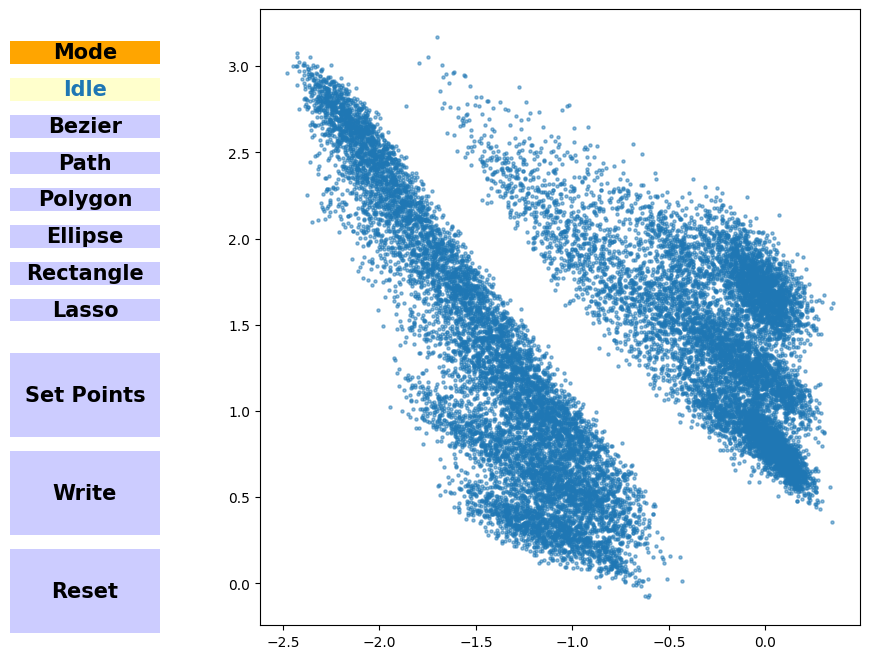

In [10]:
# %matplotlib qt5
%matplotlib inline
sess = em.InteractivePlotting(emap)

For static notebooks, we load the points along the path and generate new molecular conformations from them.

In [11]:
sess.statusmenu.status = "Bezier"
sess.ball_and_stick = True
sess.path_points = np.load("path.npy")
sess.tool.ind = np.load("path.npy")
sess.set_points()

/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


View the generated traj:

In [12]:
sess.view

NGLWidget(max_frame=199)